# Anjali Singh
202318050

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c3849e10e8cc897f596eb03385cfa1ba47e6e751ee7363a3edaf774d03014d70
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
pip install ucimlrepo

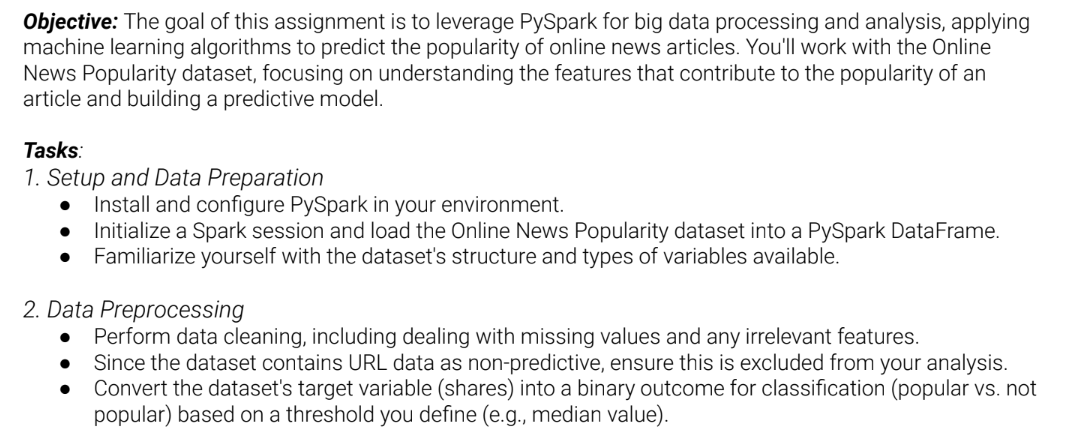

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetching dataset
online_news_popularity = fetch_ucirepo(id=332)

X = online_news_popularity.data.features
y = online_news_popularity.data.targets

# # metadata
# print("\nMetadata:")
# print(online_news_popularity.metadata)

# # variable information
# print("\nVariable information:")
# print(online_news_popularity.variables)

In [ ]:
from pyspark.sql import SparkSession
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("OnlineNewsPopularity").getOrCreate()

# Merging X and y into a single DataFrame
df_combined = pd.concat([X, y], axis=1)

# Convert the merged DataFrame to PySpark DataFrame without explicitly defining a schema
df_spark = spark.createDataFrame(df_combined)

# Show the first few rows of the PySpark DataFrame
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# # Task 1: Setup and Data Preparation
# # Initialize a Spark session
# spark = SparkSession.builder.appName("NewsPopularity").getOrCreate()

# # Load the Online News Popularity dataset into a PySpark DataFrame
# data = spark.read.csv("OnlineNewsPopularity.csv", header=True, inferSchema=True)

# Print the dataset schema to understand its structure
df_spark.printSchema()

# Task 2: Data Preprocessing
# Remove irrelevant features, including the URL column (already excluded in the schema)
# Convert the 'shares' column to a binary outcome (popular vs. not popular)
median_shares = df_spark.approxQuantile(" shares", [0.5], 0.0)[0]
data = df_spark.withColumn("label", when(col(" shares") >= median_shares, 1).otherwise(0))

# Select features for the model and assemble them into a feature vector
feature_columns = [col for col in data.columns if col not in ['shares', 'label']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Task 3: Model Training and Evaluation
# Create a RandomForestClassifier model
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label")

# Define a Pipeline that includes feature assembly and the classifier
pipeline = Pipeline(stages=[assembler, rf_classifier])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using the BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.2f}")


root
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: double (nullable = true)
 |--  kw_avg_min: double (nullable = true)
 |--  kw_mi

In [ ]:
print("\nSummary statistics:")
df_spark.describe().show()


Summary statistics:
+-------+------------------+-----------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------------+---------------------------+------------------

In [ ]:
# Drop rows with any null values
df_cleaned = df_spark.na.drop()

# Show the first few rows of the cleaned DataFrame
df_cleaned.show(5)

# Display summary statistics for the cleaned features
print("\nSummary statistics for cleaned features:")
df_cleaned.describe().show()

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
from pyspark.sql.functions import when, col

median_shares = df_spark.approxQuantile(" shares", [0.5], 0.01)[0]
df_spark = df_cleaned.withColumn("shares_binary", when(col(" shares") >= median_shares, 1).otherwise(0))

# Show the first few rows of the preprocessed DataFrame
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

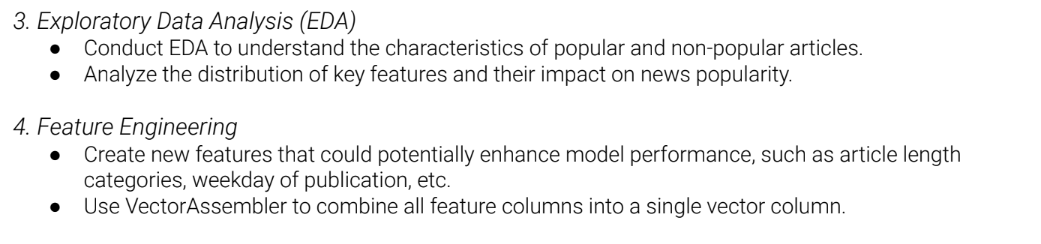

In [ ]:
from pyspark.sql.functions import col, count, mean, stddev, corr

# Summary statistics for popular and non-popular articles
df_grouped = df_spark.groupby("shares_binary").agg(
    count("*").alias("count"),
    mean(" n_tokens_title").alias("avg_title_length"),
    mean(" n_tokens_content").alias("avg_content_length"),
    mean(" num_hrefs").alias("avg_num_hrefs"),
    mean(" num_imgs").alias("avg_num_imgs"),
    mean(" num_videos").alias("avg_num_videos"),
    mean(" shares").alias("avg_shares"),
    mean(" global_subjectivity").alias("avg_global_subjectivity"),
    mean(" global_sentiment_polarity").alias("avg_global_sentiment_polarity"),
    mean(" rate_positive_words").alias("avg_rate_positive_words"),
    mean(" rate_negative_words").alias("avg_rate_negative_words")
)

df_grouped.show()

# Distribution of key features for popular and non-popular articles
features = [
    " n_tokens_title", " n_tokens_content", " num_hrefs", " num_imgs",
    " num_videos", " global_subjectivity", " global_sentiment_polarity",
    " rate_positive_words", " rate_negative_words"
]

for feature in features:
    df_spark.groupby("shares_binary").agg(
        mean(col(feature)).alias(f"avg_{feature}"),
        stddev(col(feature)).alias(f"stddev_{feature}")
    ).show()

# Correlation analysis between features and the target variable
for feature in features:
    correlation = df_spark.stat.corr(feature, "shares_binary")
    print(f"Correlation between {feature} and shares_binary: {correlation:.2f}")

+-------------+-----+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------+-----------------------------+-----------------------+-----------------------+
|shares_binary|count|  avg_title_length|avg_content_length|     avg_num_hrefs|      avg_num_imgs|    avg_num_videos|       avg_shares|avg_global_subjectivity|avg_global_sentiment_polarity|avg_rate_positive_words|avg_rate_negative_words|
+-------------+-----+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------+-----------------------------+-----------------------+-----------------------+
|            1|21154|10.311761369008225| 564.7633544483313|11.839604802874161| 5.066134064479531|1.2781034319750402|5568.213860262835|     0.4507946492337189|           0.1259741737156871|     0.6897556240000232|    0.27753188663626893|
|            0|18490|10.498269334775554|  525.636884

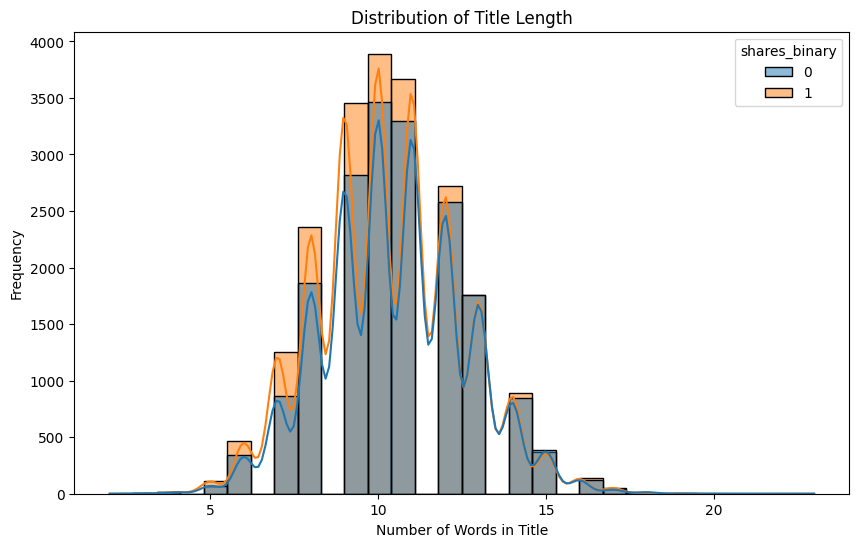

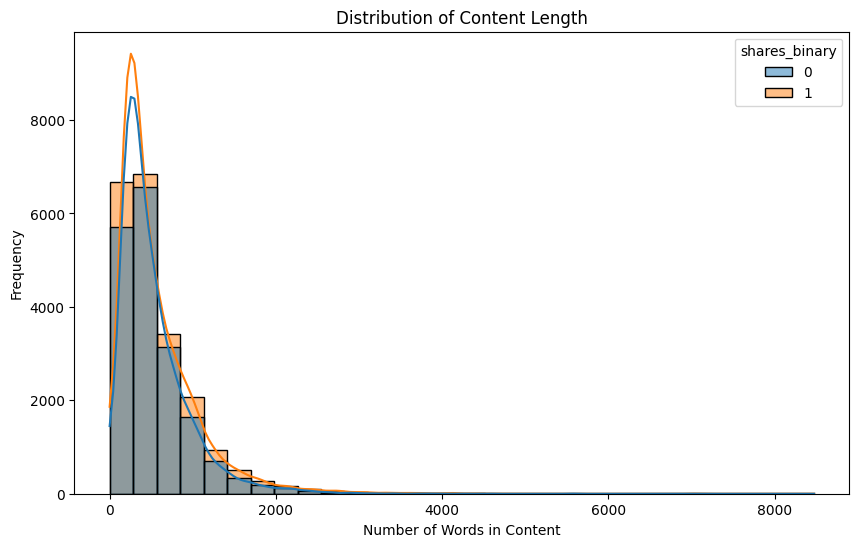

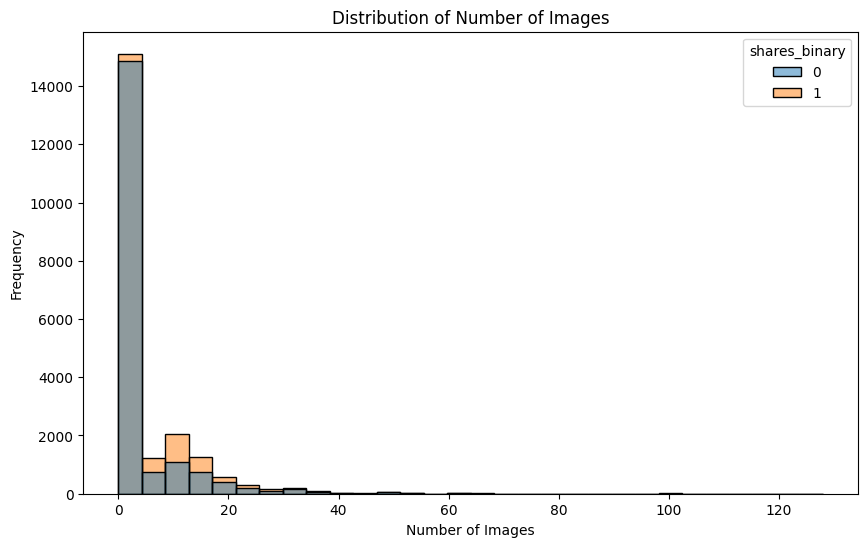

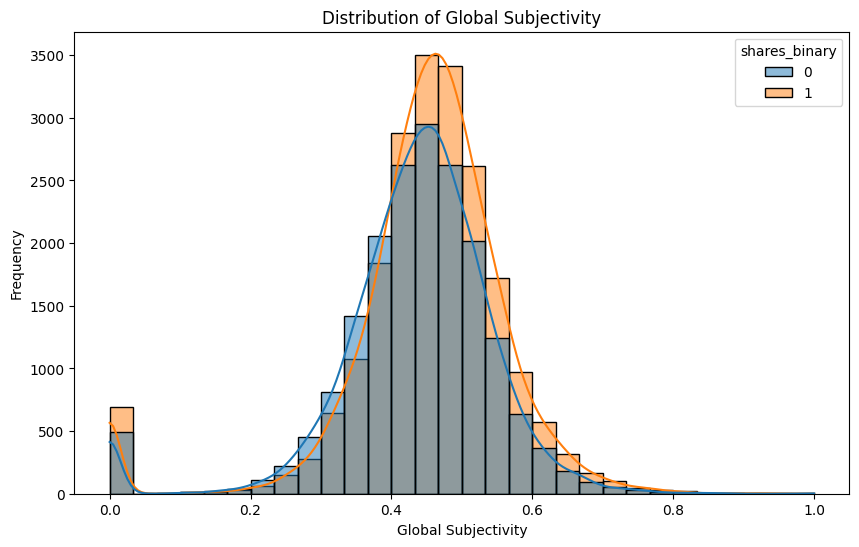

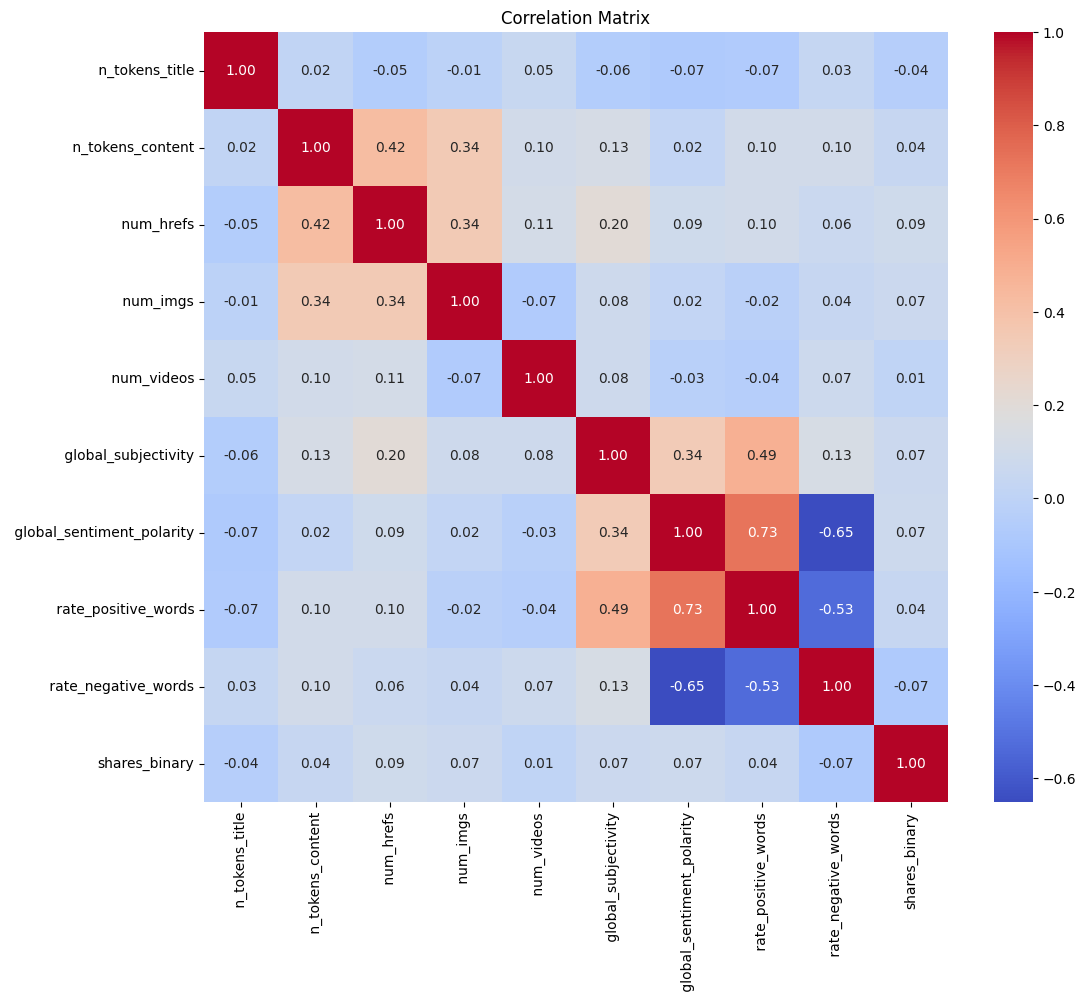

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_spark.toPandas()

# Plotting the distribution of the number of words in the title
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" n_tokens_title", hue="shares_binary", bins=30, kde=True)
plt.title("Distribution of Title Length")
plt.xlabel("Number of Words in Title")
plt.ylabel("Frequency")
plt.show()

# Plotting the distribution of the number of words in the content
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" n_tokens_content", hue="shares_binary", bins=30, kde=True)
plt.title("Distribution of Content Length")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.show()

# Plotting the distribution of the number of images
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" num_imgs", hue="shares_binary", bins=30, kde=False)
plt.title("Distribution of Number of Images")
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.show()

# Plotting the distribution of global subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(data=df_pandas, x=" global_subjectivity", hue="shares_binary", bins=30, kde=True)
plt.title("Distribution of Global Subjectivity")
plt.xlabel("Global Subjectivity")
plt.ylabel("Frequency")
plt.show()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = df_pandas[features + ["shares_binary"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


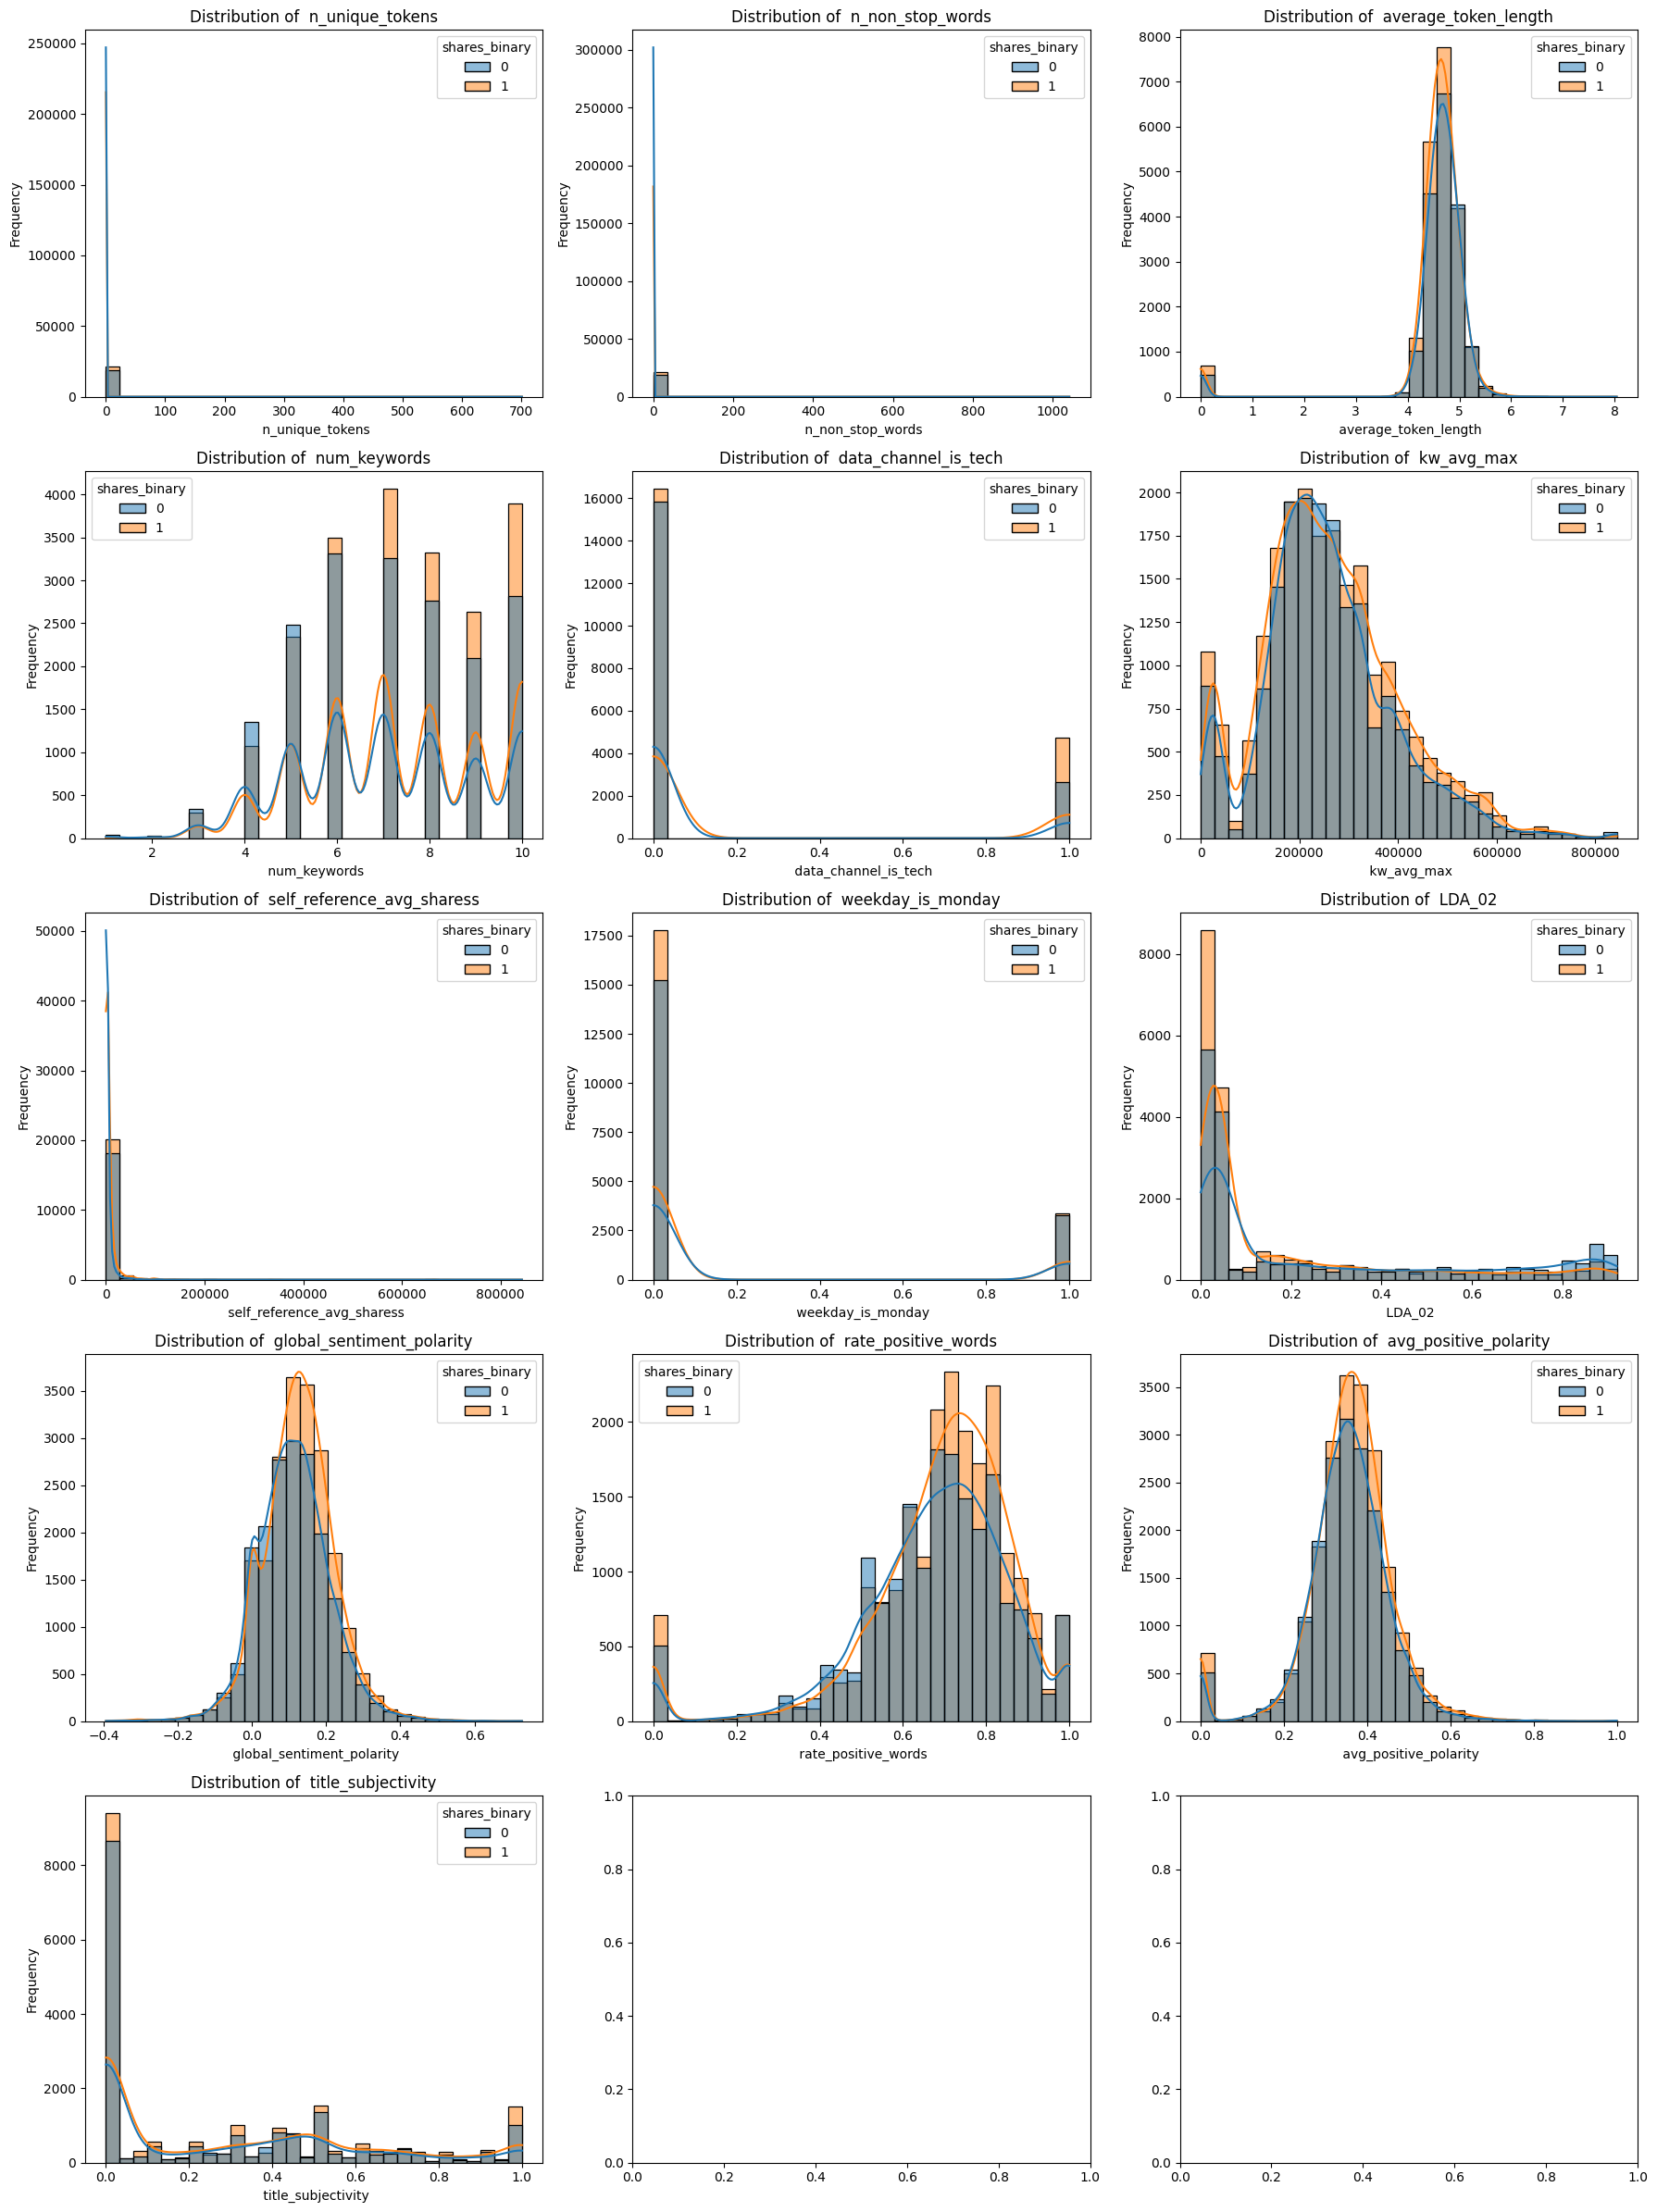

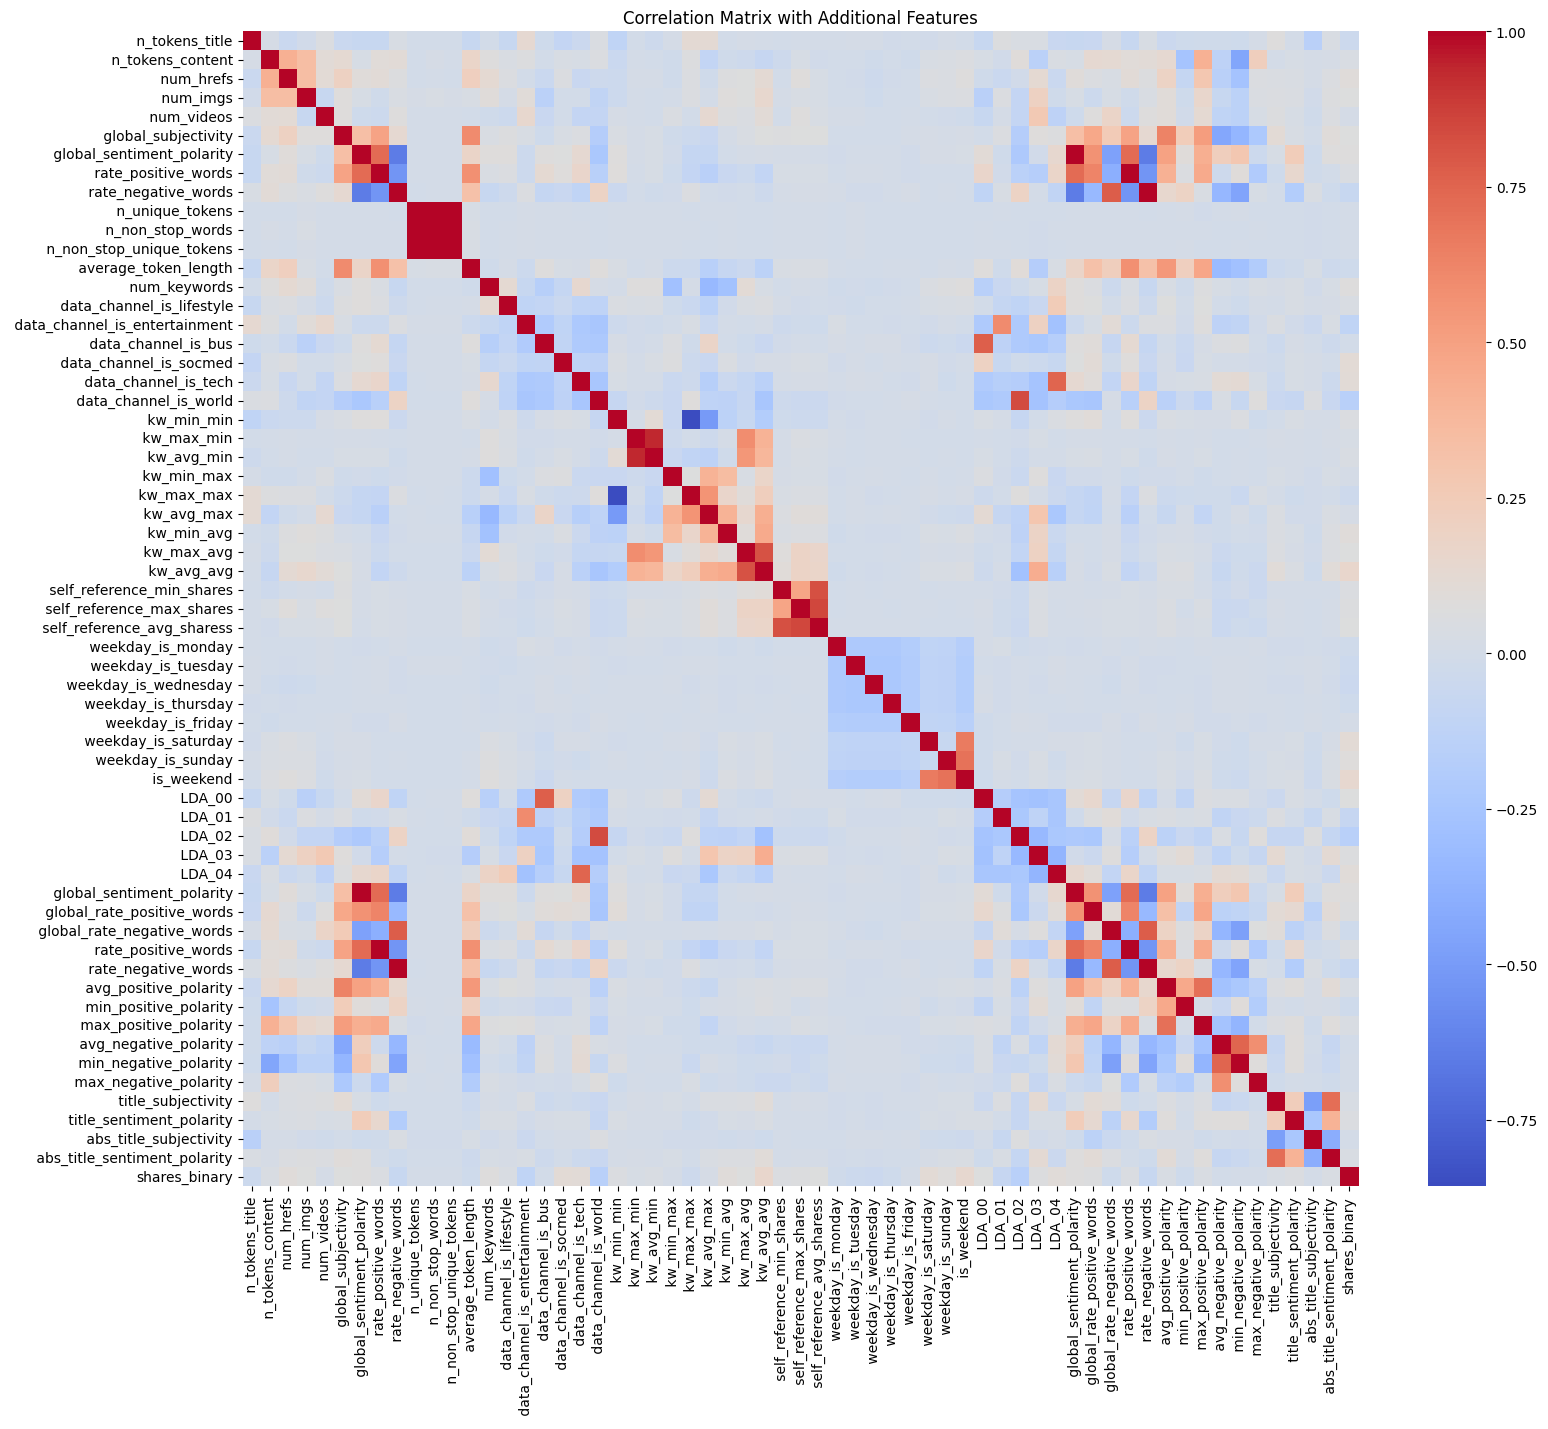

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
df_pandas = df_spark.toPandas()

# List of additional features for EDA
additional_features = [
    " n_unique_tokens", " n_non_stop_words", " n_non_stop_unique_tokens",
    " average_token_length", " num_keywords", " data_channel_is_lifestyle",
    " data_channel_is_entertainment", " data_channel_is_bus",
    " data_channel_is_socmed", " data_channel_is_tech", " data_channel_is_world",
    " kw_min_min", " kw_max_min", " kw_avg_min", " kw_min_max",
    " kw_max_max", " kw_avg_max", " kw_min_avg", " kw_max_avg", " kw_avg_avg",
    " self_reference_min_shares", " self_reference_max_shares",
    " self_reference_avg_sharess", " weekday_is_monday", " weekday_is_tuesday",
    " weekday_is_wednesday", " weekday_is_thursday", " weekday_is_friday",
    " weekday_is_saturday", " weekday_is_sunday", " is_weekend",
    " LDA_00", " LDA_01", " LDA_02", " LDA_03", " LDA_04",
    " global_sentiment_polarity", " global_rate_positive_words",
    " global_rate_negative_words", " rate_positive_words", " rate_negative_words",
    " avg_positive_polarity", " min_positive_polarity", " max_positive_polarity",
    " avg_negative_polarity", " min_negative_polarity", " max_negative_polarity",
    " title_subjectivity", " title_sentiment_polarity",
    " abs_title_subjectivity", " abs_title_sentiment_polarity"
]

# Plotting histograms for selected features
selected_features = [
    " n_unique_tokens", " n_non_stop_words", " average_token_length",
    " num_keywords", " data_channel_is_tech", " kw_avg_max",
    " self_reference_avg_sharess", " weekday_is_monday", " LDA_02",
    " global_sentiment_polarity", " rate_positive_words", " avg_positive_polarity",
    " title_subjectivity"
]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.histplot(data=df_pandas, x=feature, hue="shares_binary", bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Correlation analysis with additional features
corr_features = features + additional_features + ["shares_binary"]
corr_matrix = df_pandas[corr_features].corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".2f", annot=False)
plt.title("Correlation Matrix with Additional Features")
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg

# Assuming spark is your SparkSession
# df_spark is your PySpark DataFrame

# Calculate the average of n_tokens_title for popular and non-popular articles
avg_n_tokens_title_popular = df_spark.filter(col("shares_binary") == 1).agg(avg(" n_tokens_title")).collect()[0][0]
avg_n_tokens_title_non_popular = df_spark.filter(col("shares_binary") == 0).agg(avg(" n_tokens_title")).collect()[0][0]

print("Average n_tokens_title for Popular Articles:", avg_n_tokens_title_popular)
print("Average n_tokens_title for Non-Popular Articles:", avg_n_tokens_title_non_popular)

Average n_tokens_title for Popular Articles: 10.311761369008225
Average n_tokens_title for Non-Popular Articles: 10.498269334775554


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when

# Assuming spark is your SparkSession
# df_spark is your PySpark DataFrame

# Create a new feature for article length categories
df_spark = df_spark.withColumn(" article_length_category",
                               when(col(" n_tokens_content") < 500, "Short")
                               .when((col(" n_tokens_content") >= 500) & (col(" n_tokens_content") < 1000), "Medium")
                               .otherwise("Long"))

# Create a new feature for the weekday of publication
weekday_columns = [" weekday_is_monday", " weekday_is_tuesday", " weekday_is_wednesday",
                    " weekday_is_thursday", " weekday_is_friday", " weekday_is_saturday", " weekday_is_sunday"]

df_spark = df_spark.withColumn("publication_weekday",
                               when(col(" weekday_is_monday") == 1, "Monday")
                               .when(col(" weekday_is_tuesday") == 1, "Tuesday")
                               .when(col(" weekday_is_wednesday") == 1, "Wednesday")
                               .when(col(" weekday_is_thursday") == 1, "Thursday")
                               .when(col(" weekday_is_friday") == 1, "Friday")
                               .when(col(" weekday_is_saturday") == 1, "Saturday")
                               .when(col(" weekday_is_sunday") == 1, "Sunday")
                               .otherwise("Unknown"))

# Show the first few rows of the DataFrame with new features
df_spark.show(5)

+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+----------

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Indexing categorical features
indexers = [
    StringIndexer(inputCol=' article_length_category', outputCol='article_length_category_index'),
    StringIndexer(inputCol='weekday_of_publication', outputCol='weekday_of_publication_index')
]

# One-hot encoding
encoders = [
    OneHotEncoder(inputCols=['article_length_category_index', 'weekday_of_publication_index'],
                  outputCols=['article_length_category_vec', 'weekday_of_publication_vec'])
]

# Use VectorAssembler to combine all feature columns into a single vector column
feature_columns = [col for col in df_spark.columns if col not in [' shares', 'label','article_length_category_index', 'weekday_of_publication_index']]
assembler = VectorAssembler(inputCols=feature_columns + ['article_length_category_vec', 'weekday_of_publication_vec'], outputCol="features")

# Define the stages of the pipeline
from pyspark.ml import Pipeline
pipeline_stages = indexers + encoders + [assembler]

# Create the pipeline
pipeline = Pipeline(stages=pipeline_stages)

# Fit the pipeline to the DataFrame
df_spark = pipeline.fit(df_spark).transform(df_spark)

Py4JJavaError: An error occurred while calling o495.fit.
: org.apache.spark.SparkException: Input column weekday_of_publication does not exist.
	at org.apache.spark.ml.feature.StringIndexerBase.$anonfun$validateAndTransformSchema$2(StringIndexer.scala:128)
	at scala.collection.TraversableLike.$anonfun$flatMap$1(TraversableLike.scala:293)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at scala.collection.TraversableLike.flatMap(TraversableLike.scala:293)
	at scala.collection.TraversableLike.flatMap$(TraversableLike.scala:290)
	at scala.collection.mutable.ArrayOps$ofRef.flatMap(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema(StringIndexer.scala:123)
	at org.apache.spark.ml.feature.StringIndexerBase.validateAndTransformSchema$(StringIndexer.scala:115)
	at org.apache.spark.ml.feature.StringIndexer.validateAndTransformSchema(StringIndexer.scala:145)
	at org.apache.spark.ml.feature.StringIndexer.transformSchema(StringIndexer.scala:252)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:237)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:145)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
